In [71]:
#To-do: to fix the order of position so that signal can be registered!! 

import numpy as np
import pandas as pd
from openpyxl import load_workbook

import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

import requests
from termcolor import colored as cl 
plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)



In [72]:
# data import 
df = pd.read_excel('Test Bed V2 (Pairs Trades).xlsm', header = 1, usecols = ['Series 18','Series 28'])
column_headers = list(df.columns.values)
pair1 = column_headers[0]
pair2 = column_headers[1]
df.head(10)


,Series 18,Series 28
0,100.000000,100.000000
1,99.972150,100.122648
2,100.069066,99.914545
3,99.892623,99.746851
4,99.813692,99.722504
5,99.837196,99.895837
6,99.845534,100.039474
7,99.874615,100.082817
8,99.964270,100.123589
9,100.002189,100.312690


In [73]:
# Trade strategy: normalise the ratio and trade based on z-score 
# Note: profit is compared against the avereaged return from buy-and-hold of the two strategies

def trade(S1, S2, shortMA, longMA, STD, z_score_bound, sizing):

    ratios = S1/ S2 
    ratios_mavgshort = ratios.rolling(window=shortMA, center=False).mean()
    ratios_mavglong = ratios.rolling(window=longMA, center=False).mean()
    std_hist = ratios.rolling(window=STD, center=False).std()
    zscore = (ratios_mavgshort - ratios_mavglong)/std_hist

    # Start with no money and no positions
    money = 0
    money_list = []
    signalS1 = []
    signalS2 = []
    positionS1 = []
    positionS2 = []
    
    for i in range(len(S1)):    
        positionS1.append(0)
        positionS2.append(0)
    
    for i in range(len(ratios)):
        if i == (len(ratios)-1) : 
            money += S1.iloc[i] * positionS1[i-1] + S2.iloc[i] * positionS2[i-1]
            signalS1.append(-positionS1[i-1])
            signalS2.append(-positionS2[i-1])
  
        elif (zscore.iloc[i] > z_score_bound) and (abs(positionS1[i-1]) < 45) and (abs(positionS2[i-1]) < 45):
            money += S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            signalS1.append(-sizing)
            signalS2.append(sizing*ratios.iloc[i])
              
        elif (zscore.iloc[i] < -z_score_bound) and (abs(positionS1[i-1]) < 45) and (abs(positionS2[i-1]) < 45):
            money -= S1.iloc[i] - S2.iloc[i] * ratios.iloc[i]
            signalS1.append(sizing)
            signalS2.append(-sizing*ratios.iloc[i])
  
        elif (abs(zscore.iloc[i]) < z_score_bound) and (positionS1[i-1] < -10):
            money += S1.iloc[i] * -10 + S2.iloc[i] * 10 * ratios.iloc[i] 
            signalS1.append(10)
            signalS2.append(-10 * ratios.iloc[i])
            
        elif (abs(zscore.iloc[i]) < z_score_bound) and (positionS1[i-1] > 10):
            money += S1.iloc[i] * 10 + S2.iloc[i] * -10 * ratios.iloc[i] 
            signalS1.append(-10)
            signalS2.append(10 * ratios.iloc[i])

        elif (abs(zscore.iloc[i]) < z_score_bound) and (positionS2[i-1] < -10):
            money += S1.iloc[i] * 10 / ratios.iloc[i] + S2.iloc[i] * -10 
            signalS1.append(-10/ ratios.iloc[i])
            signalS2.append(10)

        elif (abs(zscore.iloc[i]) < z_score_bound) and (positionS2[i-1] > 10):
            money += S1.iloc[i] * -10 / ratios.iloc[i]  + S2.iloc[i] * 10 
            signalS1.append(10/ ratios.iloc[i])
            signalS2.append(-10)
            
        elif (abs(zscore.iloc[i]) < z_score_bound) and (positionS1[i-1] > -10) and (positionS1[i-1] < 10) and (positionS2[i-1] > -10) and (positionS2[i-1] < 10):
            money += S1.iloc[i] * positionS1[i-1] + S2.iloc[i] * positionS2[i-1]
            signalS1.append(-1*positionS1[i-1])
            signalS2.append(-1*positionS2[i-1])

        else:
            money = money 
            signalS1.append(0)
            signalS2.append(0)
        
        money_list.append(money* 10000)
        positionS1[i] = positionS1[i-1] + signalS1[i]
        positionS2[i] = positionS2[i-1] + signalS2[i]

    return positionS1, positionS2, signalS1, signalS2, money, zscore, money_list, ratios
    



In [74]:
def sharpe_ratio(S1, S2, positionS1, positionS2):
    
    dailyreturnS1 = [0]
    postadj_dailyreturnS1 = []
    dailyreturnS2 = [0]
    postadj_dailyreturnS2 = []
    combinedreturn = []
    excessreturn = []
    rf_rate = 0.02

    for i in range(len(S1)-1):
        dailyreturnS1.append((S1.iloc[i+1] - S1.iloc[i])/ S1.iloc[i])
        dailyreturnS2.append((S2.iloc[i+1] - S2.iloc[i])/ S2.iloc[i])
    
    for i in range(len(S1)):
        postadj_dailyreturnS1.append(dailyreturnS1[i] * positionS1[i])
        postadj_dailyreturnS2.append(dailyreturnS2[i] * positionS2[i])
        combinedreturn.append(postadj_dailyreturnS1[i] + postadj_dailyreturnS2[i])
        excessreturn.append(combinedreturn[i] - rf_rate)
    sharpe = ((np.mean(excessreturn)) / np.std(excessreturn)) * (256 ** 0.5)
    return sharpe


In [75]:

for i in range(1, 10, 1):
    i = i
    gain = trade(df[key].iloc[:], df[value].iloc[:], 10, 65, 65, 0.95, i)
    sharpe = sharpe_ratio(df[key], df[value], gain[0], gain[1])
    print(f"{i}: {sharpe}")


1: -11.351718859061423
2: -8.150418865167447
3: -7.137228815185585
4: -6.534972584563947
5: -6.451265785600732
6: -5.954511004693951
7: -5.785957656237291
8: -5.8546145568184444
9: -6.181719207197725


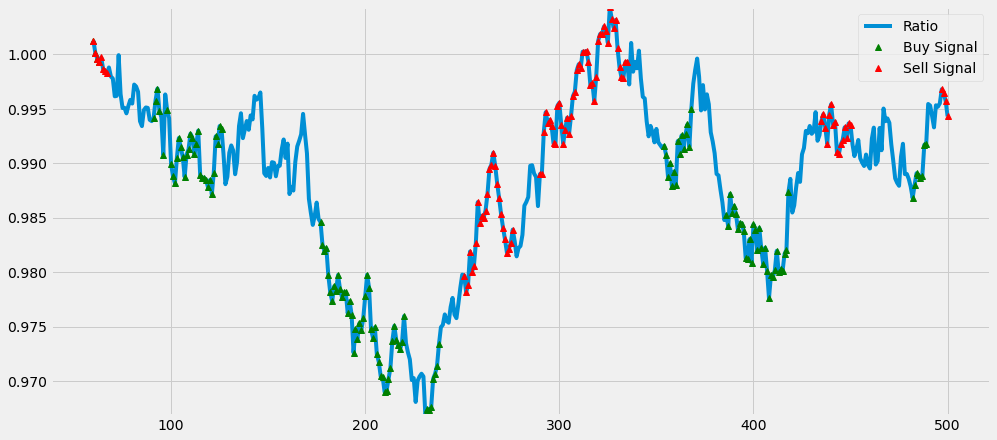

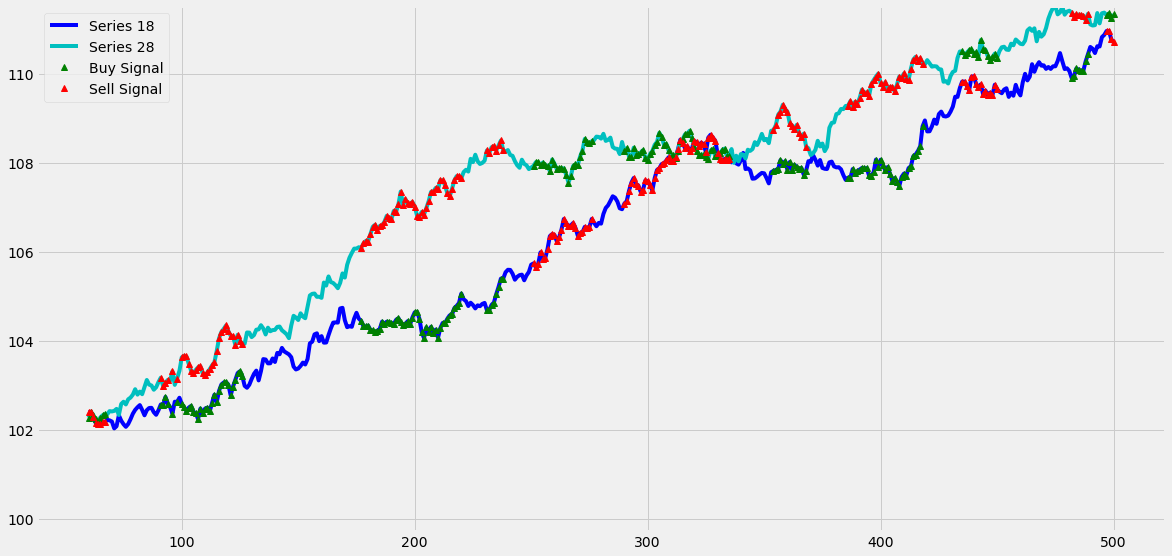

In [76]:
# Graph Plotting
ratios = df[pair1] / df[pair2]
test_period = ratios[:]


# Plot the ratios and buy and sell signals from z score
gain = trade(df[pair1].iloc[:], df[pair2].iloc[:], 10, 65, 65, 0.95, 3)
sharpe = sharpe_ratio(df[pair1].iloc[:], df[pair2].iloc[:], gain[0], gain[1])

plt.figure(figsize=(15,7))
test_period[60:].plot()
buy = test_period.copy()
sell = test_period.copy()
buy[gain[5]>-1] = 0
sell[gain[5]<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = df[pair1].iloc[:]
S2 = df[pair2].iloc[:]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()


# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['Series 18','Series 28', 'Buy Signal', 'Sell Signal'])
plt.show()

Series 18 " and " Series 28 "has a sharpe of" -7.137228815185585 and a profit of 329666.5535175526


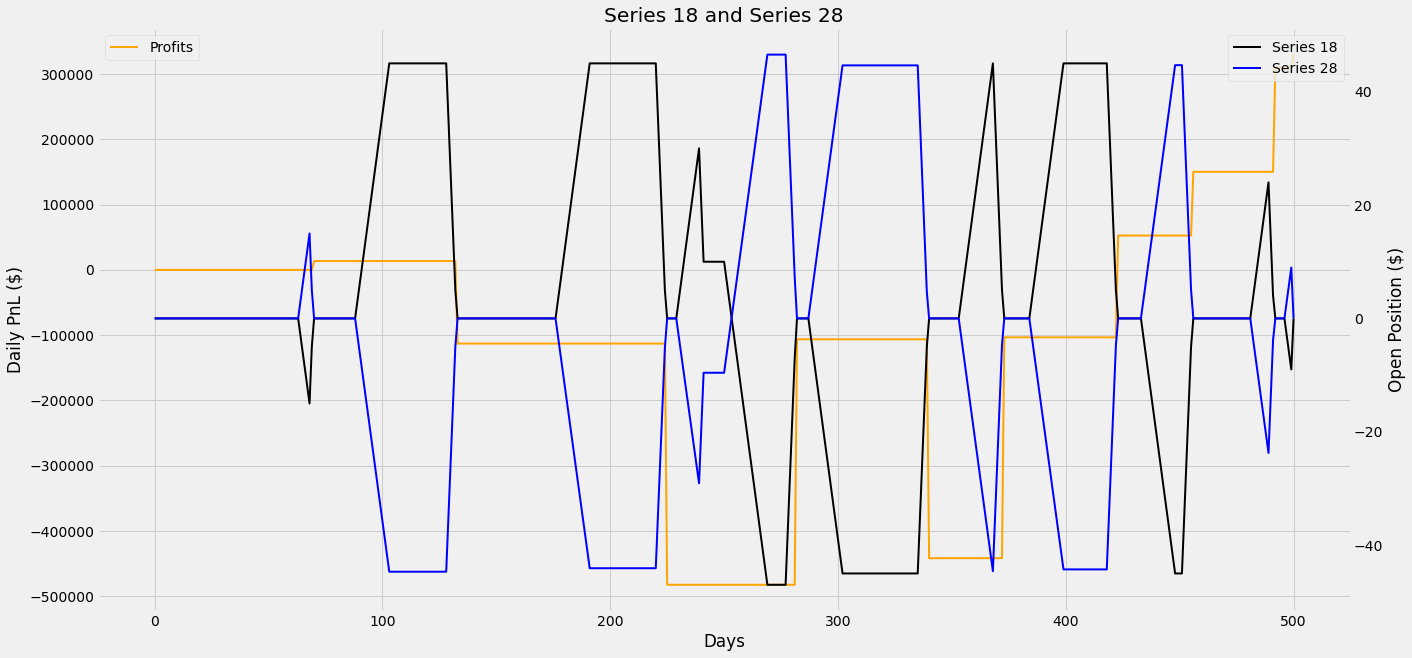

In [78]:
# Plotting

result = pd.DataFrame()

gain = trade(df[pair1].iloc[:], df[pair2].iloc[:], 10, 65, 65, 0.95, 3)
result[pair1] = gain[6]
result['Position of' + pair1] = gain[0]
result['Position of' + pair2] = gain[1]

sharpe = sharpe_ratio(df[pair1].iloc[:], df[pair2].iloc[:], gain[0], gain[1])

print(f'{key} " and " {value} "has a sharpe of" {sharpe} and a profit of {gain[4]*10000}' )

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df.index[:], result[pair1].iloc[:], linewidth=2, label='Profits', color='orange')
ax2 = ax.twinx()
ax2.plot(df.index[:], result['Position of' + pair1].iloc[:], linewidth=2, label=pair1, color='black')
ax2.plot(df.index[:], result['Position of' + pair2].iloc[:], linewidth=2, label=pair2, color='blue')
ax.set_title(pair1 + ' and ' + pair2)
ax.set_xlabel('Days')
ax2.set_ylabel('Open Position ($)')
ax.set_ylabel('Daily PnL ($)')
ax2.grid(False)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
            

In [107]:
workbook = load_workbook(filename='Test Bed V2 (Pairs Trades).xlsm', read_only=False, keep_vba=True)
sheet = workbook.active
sheet["AH1"] = pair1[-2:] 
sheet["AN1"] = pair2[-2:] 
sheet["AU1"] = 0
sheet["BA1"] = 0
sheet["BH1"] = 0
sheet["BN1"] = 0

for i in range(len(df[pair1])):
    sheet["AG"+ str(i+3)] = gain[2][i]*10000
    sheet["AM"+ str(i+3)] = gain[3][i]*10000
    sheet["AT"+ str(i+3)] = 0
    sheet["AZ"+ str(i+3)] = 0
    sheet["BG"+ str(i+3)] = 0
    sheet["BM"+ str(i+3)] = 0

workbook.save(filename='Test Bed V2 (Pairs Trades).xlsm')
